# Configuração

In [52]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'voos-aerocongonhas:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F4455930%2F7644634%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240217%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240217T192913Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D548984684b9f7e7449966fd1cd31f791fa996b00f04c1b5932a68fb094609ad1c568092c4b1508cbbd30e23ec4cd87122f3b1dd5b8ec338472924431fee706fc7c1278ecd42a5fea9d464edb2691f0b715834548eed2a3c2aab83a3b8d23a79eb13b61a3855f0f3a157841327a920fb7192a0ffc66221e922fd40ebd6459b61156cbf5d4d9ee6db335540791e493a49ca083539ff6f65bf751c0f928ffa878985621dfb6512f55b11b623584efe2df9b0affbac5a78525db2d137a022be3c5ed5c8292531a8055b279a275b544d16d6017d76e16056b851611feb8062a96482fdf79cf6b67ed153ff313ae3acdfa3455ee45928dcc4e5f6b7ddae8565ba9deb6'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 2966 bytes downloaded
Downloaded and uncompressed: voos-aerocongonhas
Data source import complete.


In [53]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import plotly.graph_objects as go


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/voos-aerocongonhas/extended_flights_data.csv


### Colunas:
* ScheduledTime: Horário programado para o voo.
* ActualTime: Horário real de partida do voo.
* Delay: Atraso na partida do voo.
* FlightNumber: Número do voo.
* Destination: Destino do voo.
* Gate: Portão de embarque.
* FlightStatus: Status do voo.

In [54]:
# Caminho para o arquivo CSV
file_path = '/content/extended_flights_data.csv'

# Ler o arquivo CSV especificando o separador correto e a codificação
df = pd.read_csv(file_path, sep=';', encoding='ISO-8859-1')

# Exibir as primeiras linhas do DataFrame para verificar
df.head()

,ScheduledTime,ActualTime,Delay,FlightNumber,Destination,Gate,FlightStatus
0,06:00,06:09,00:09,GLO1402,BRASILIA,11,VOO ENCERRADO
1,06:00,06:19,00:19,TAM3000,BRASILIA,5,VOO ENCERRADO
2,06:00,06:00,00:00,GLO1000,RIO DE JANEIRO / SANTOS DUMONT,-,CANCELADO
3,06:05,06:14,00:09,GLO1594,SALVADOR /LUIS R. MAGALHAES,10,VOO ENCERRADO
4,06:10,06:26,00:16,TAM3252,FLORIANOPOLIS/HERCILIO LUZ,13,VOO ENCERRADO


In [55]:
df.count()

ScheduledTime    185
ActualTime       169
Delay            172
FlightNumber     185
Destination      185
Gate             183
FlightStatus     185
dtype: int64

# Voôs por Companhia Aérea

In [56]:
# Definir a coluna 'Airline' como as 3 primeiras letras de 'FlightNumber'
df['Airline'] = df['FlightNumber'].str[:3]

# Dicionário de mapeamento das siglas para os nomes completos das companhias aéreas
airline_names = {
    'TAM': 'TAM Linhas Aéreas',
    'GLO': 'Gol Linhas Aéreas',
    'AZU': 'Azul Linhas Aéreas',
    'PTB': 'Passaredo Linhas Aéreas',
    'ACN': 'Avianca Brasil'
}

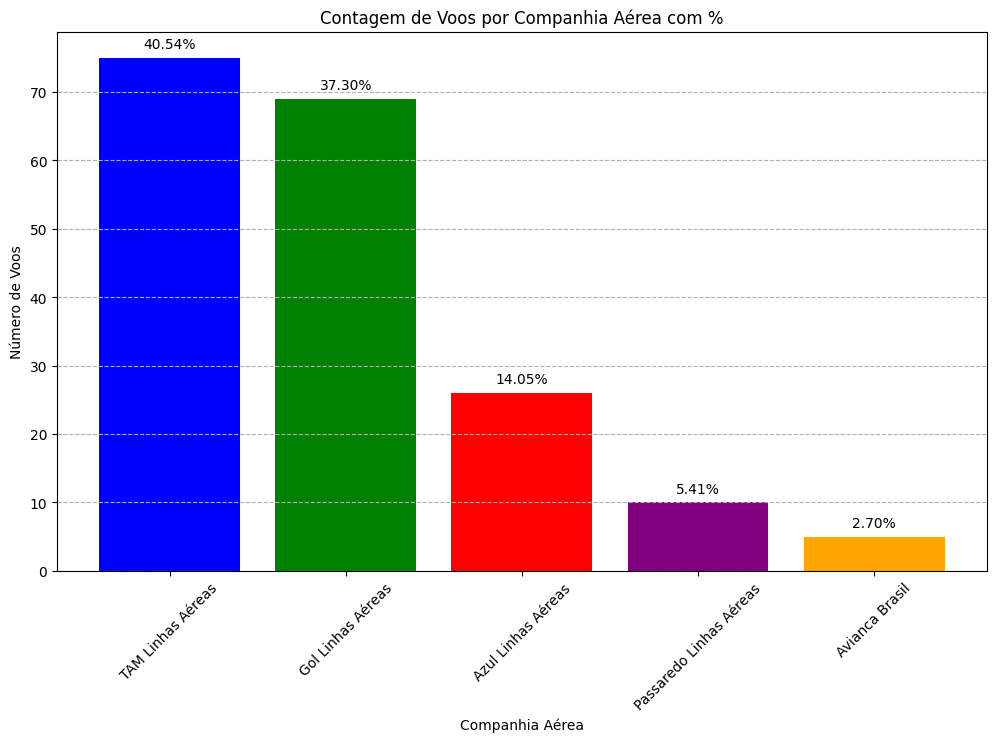

In [57]:
# Gerar um gráfico de barras com rótulos de porcentagem, cores diferentes e nomes completos das companhias aéreas

colors = ['blue', 'green', 'red', 'purple', 'orange']
airline_flight_counts = df['Airline'].value_counts()

plt.figure(figsize=(12, 7))
bars = plt.bar(airline_flight_counts.index.map(airline_names), airline_flight_counts, color=colors)

# Calcular o total de voos
total_flights = airline_flight_counts.sum()

# Calcular as porcentagens para cada companhia aérea
percentage = (airline_flight_counts / total_flights) * 100

# Adicionar rótulos de porcentagem acima das barras
for bar, pct in zip(bars, percentage):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 1, f'{pct:.2f}%', ha='center', va='bottom')

plt.title('Contagem de Voos por Companhia Aérea com %')
plt.xlabel('Companhia Aérea')
plt.ylabel('Número de Voos')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--')

# Exibir o gráfico
plt.show()

# Atrasos

In [58]:
df['DelayMinutes'] = df['Delay'].str.split(':').apply(lambda x: int(x[0]) * 60 + int(x[1]) if isinstance(x, list) and len(x) == 2 else 0)

* Por Companhia

In [69]:
# Mapear as siglas para os nomes completos usando o dicionário
df['AirlineName'] = df['Airline'].map(airline_names)

# Converter 'Delay' para minutos totais
df['DelayMinutes'] = df['Delay'].str.split(':').apply(lambda x: int(x[0]) * 60 + int(x[1]) if isinstance(x, list) and len(x) == 2 else 0)

# Calcular a média de atraso por companhia aérea
average_delay_by_airline_name = df.groupby('AirlineName')['DelayMinutes'].mean().sort_values(ascending=False)

# Exibir a média de atraso por companhia aérea
average_delay_by_airline_name

AirlineName
Avianca Brasil             19.600000
Gol Linhas Aéreas          18.710145
Azul Linhas Aéreas          9.153846
TAM Linhas Aéreas           6.533333
Passaredo Linhas Aéreas     5.600000
Name: DelayMinutes, dtype: float64

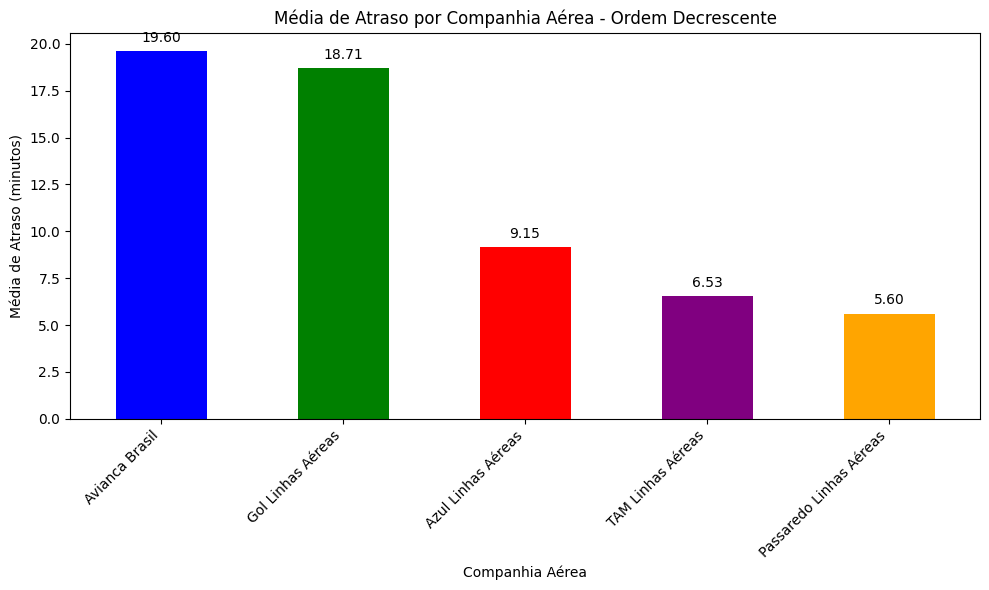

In [70]:
# Ordenar as médias de atraso em ordem decrescente
average_delay_by_airline_name_sorted = average_delay_by_airline_name.sort_values(ascending=False)

# Gerar o gráfico de barras para a média de atraso por companhia aérea
average_delay_by_airline_name_sorted.plot(kind='bar', color=['blue', 'green', 'red', 'purple', 'orange'], figsize=(10, 6))
plt.title('Média de Atraso por Companhia Aérea - Ordem Decrescente')
plt.xlabel('Companhia Aérea')
plt.ylabel('Média de Atraso (minutos)')
plt.xticks(rotation=45, ha='right')

# Adicionar rótulos de valor acima de cada barra
for index, value in enumerate(average_delay_by_airline_name_sorted):
    plt.text(index, value + 0.5, f'{value:.2f}', ha='center')

# Exibir o gráfico
plt.tight_layout()
plt.show()

* Por Destino

In [71]:
# Calcular a média de atraso por destino
average_delay_by_destination = df.groupby('Destination')['DelayMinutes'].mean().sort_values(ascending=False)

average_delay_by_destination

Destination
NATAL-GOVERNADOR ALUÃZIO ALVES            58.000000
GOVERNADOR JOSÉ RICHA                      37.500000
AEROPORTO DE JUNDIAÍ                       32.000000
ARACAJU/SANTA MARIA, SE BRAZIL             25.000000
SALVADOR /LUIS R. MAGALHAES                24.900000
BELO HORIZONTE/TANCREDO NEVES              18.714286
PORTO SEGURO                               17.600000
RIO DE JANEIRO                             16.500000
BAHIA - JORGE AMADO                        16.000000
IGUASSU FALLS / CATARATAS                  14.750000
LEITE LOPES                                12.666667
MACEIO/ZUMBI DOS PALMARES                  12.400000
BRASILIA                                   11.846154
CURITIBA/ALFONSO PENA                      11.181818
CAMPO GRANDE                               11.000000
NAVEGANTES                                 10.428571
RECIFE/GUARARAPES-GILBERTO F.               9.909091
FORTALEZA/PINTO MARTINS                     9.800000
RIO DE JANEIRO/GALEAO-INTERNAC.   

<ipython-input-91-40260555d98a>:41: UserWarning: Glyph 141 (\x8d) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 141 (\x8d) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


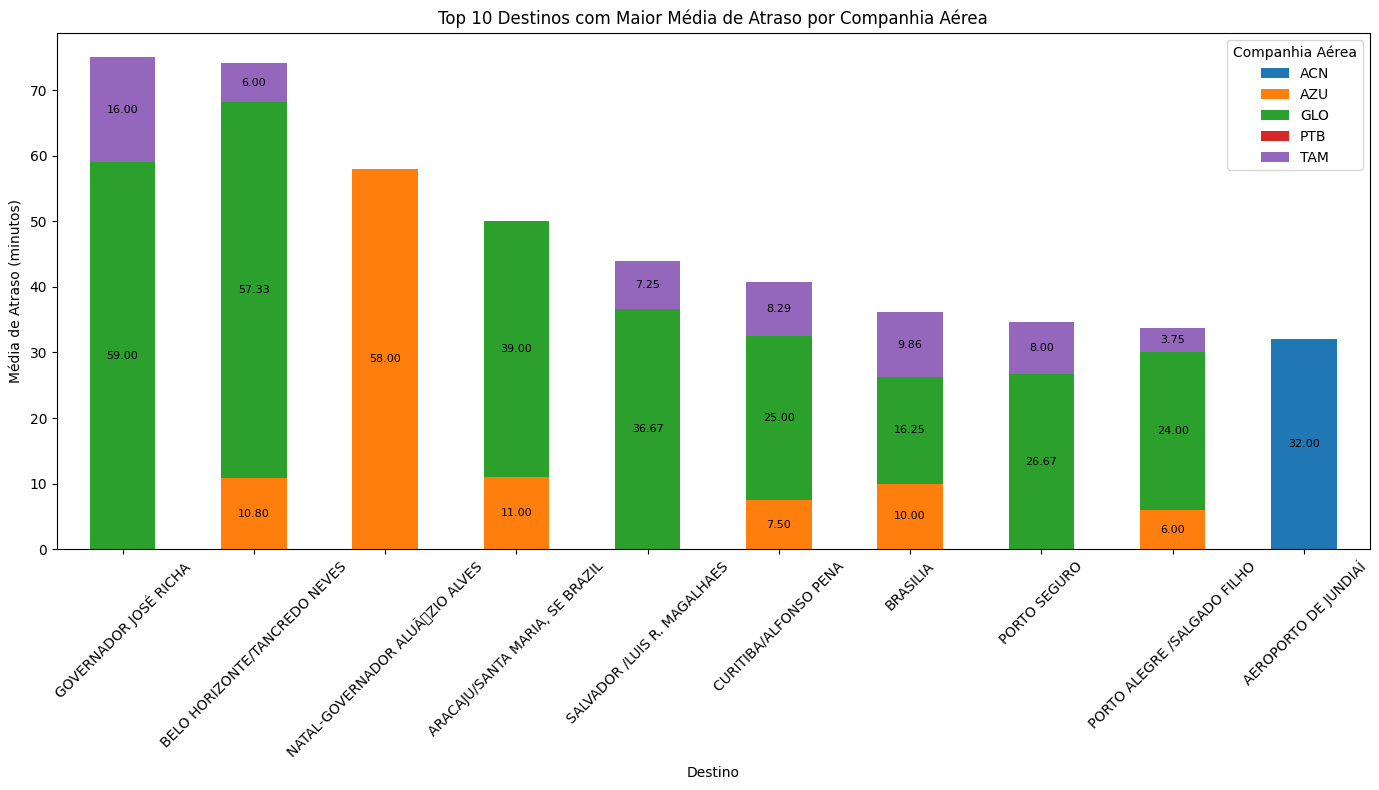

In [91]:
# Agora, você pode agrupar e calcular a média de 'DelayMinutes' para cada combinação de 'Destination' e 'Airline'
df_delays = df.groupby(['Destination', 'Airline'])['DelayMinutes'].mean().reset_index()

# Em seguida, você pode pivotar o DataFrame
pivot_df = df_delays.pivot_table(index='Destination', columns='Airline', values='DelayMinutes', aggfunc='mean')

# Ordenar as médias de atraso em ordem decrescente para os destinos e pegar o top 10
top_10_destinations = pivot_df.sum(axis=1).sort_values(ascending=False).head(10).index

# Filtrar apenas os top 10 destinos
top_delays = pivot_df.loc[top_10_destinations]

# Criar o gráfico de barras estacadas
ax = top_delays.plot(kind='bar', stacked=True, figsize=(14, 8))

# Ajustar os detalhes do gráfico
plt.title('Top 10 Destinos com Maior Média de Atraso por Companhia Aérea')
plt.xlabel('Destino')
plt.ylabel('Média de Atraso (minutos)')
plt.xticks(rotation=45)  # Girar os rótulos do eixo x para melhor visualização
plt.legend(title='Companhia Aérea')

# Adicionar rótulos de valores acima das barras
for rect in ax.patches:
    # Find where everything is located
    height = rect.get_height()
    width = rect.get_width()
    x = rect.get_x()
    y = rect.get_y()

    # The height of the bar is the data value and can be used as the label
    label_text = f'{height:.2f}'  # f'{height:.2f}' to format decimal with two decimal places

    # Don't put a label if the height is zero
    if height > 0:
        label_x = x + width / 2
        label_y = y + height / 2
        ax.text(label_x, label_y, label_text, ha='center', va='center', fontsize=8)

# Ajustar layout para evitar cortes
plt.tight_layout()

# Exibir o gráfico
plt.show()

* Por horário

In [73]:
# Converter as colunas de tempo para datetime para extrair a hora
df['ScheduledHour'] = pd.to_datetime(df['ScheduledTime'], format='%H:%M').dt.hour
df['ActualHour'] = pd.to_datetime(df['ActualTime'], format='%H:%M', errors='coerce').dt.hour

# Determinar se cada voo está atrasado
df['IsDelayed'] = df['DelayMinutes'] > 0

# Calcular a porcentagem de voos atrasados por hora programada
delay_rate_by_hour = df.groupby('ScheduledHour')['IsDelayed'].mean() * 100
delay_rate_by_hour = delay_rate_by_hour.reset_index()

print(delay_rate_by_hour)

    ScheduledHour   IsDelayed
0               6   90.476190
1               7   94.117647
2               8   73.684211
3               9  100.000000
4              10  100.000000
5              11   93.333333
6              12   90.000000
7              13   87.500000
8              14   50.000000
9              15   83.333333
10             16   77.777778
11             17   33.333333
12             18   33.333333
13             19   11.111111
14             20    0.000000
15             21    0.000000
16             22    0.000000


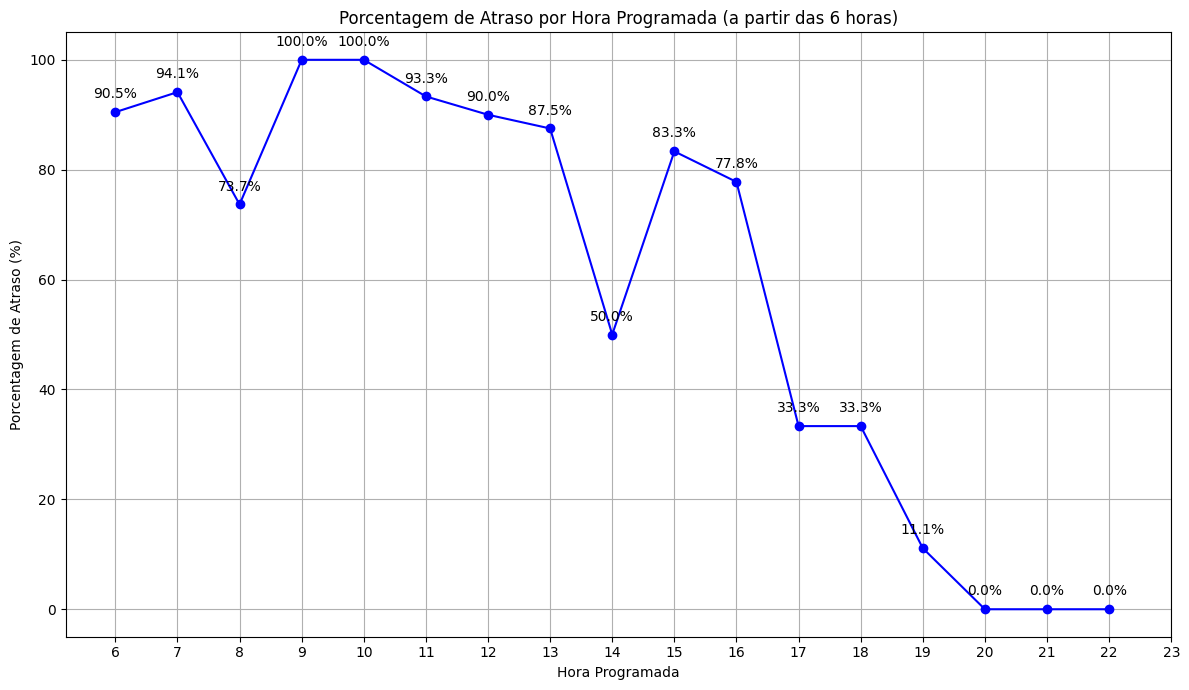

In [74]:
# Filtrar os dados para incluir apenas as horas a partir das 6 horas da manhã
delay_rate_by_hour_filtered = delay_rate_by_hour[delay_rate_by_hour['ScheduledHour'] >= 6]

# Gerar o gráfico de linha
plt.figure(figsize=(12, 7))
plt.plot(delay_rate_by_hour_filtered['ScheduledHour'], delay_rate_by_hour_filtered['IsDelayed'], marker='o', linestyle='-', color='blue')

# Adicionar rótulos de porcentagem acima de cada ponto
for x, y in zip(delay_rate_by_hour_filtered['ScheduledHour'], delay_rate_by_hour_filtered['IsDelayed']):
    label = f"{y:.1f}%"
    plt.annotate(label, (x, y), textcoords="offset points", xytext=(0,10), ha='center')

# Configurar o título e rótulos dos eixos
plt.title('Porcentagem de Atraso por Hora Programada (a partir das 6 horas)')
plt.xlabel('Hora Programada')
plt.ylabel('Porcentagem de Atraso (%)')
plt.xticks(range(6, 24))  # Configurar as marcas no eixo x para as horas do dia a partir das 6 horas
plt.grid(True)

# Exibir o gráfico
plt.tight_layout()
plt.show()


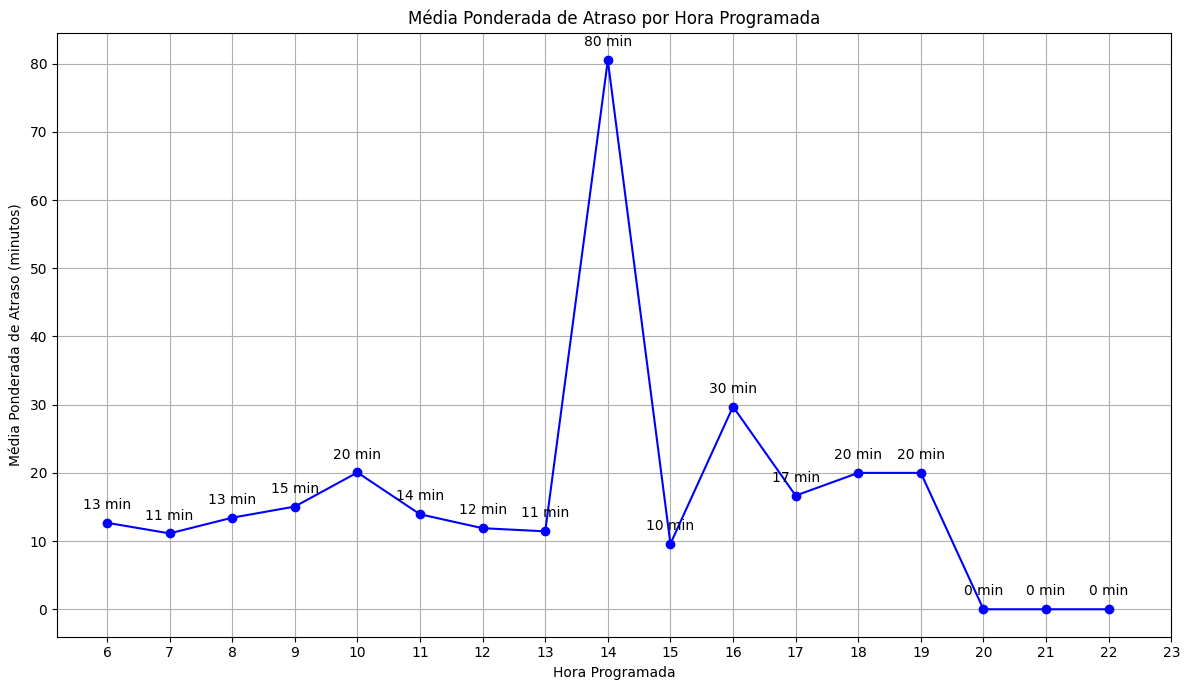

In [82]:
# Filtrar os dados para incluir apenas as horas a partir das 6 horas da manhã
df_filtered = df[df['ScheduledHour'] >= 6]

# Agrupar os dados por hora programada e calcular a média ponderada do atraso
delay_weighted_average = df_filtered.groupby('ScheduledHour').apply(
    lambda x: np.average(x['DelayMinutes'], weights=x['IsDelayed']) if np.sum(x['IsDelayed']) > 0 else 0
).reset_index(name='WeightedDelayAverage')

# Gerar o gráfico de linha
plt.figure(figsize=(12, 7))
plt.plot(delay_weighted_average['ScheduledHour'], delay_weighted_average['WeightedDelayAverage'], marker='o', linestyle='-', color='blue')

# Adicionar rótulos de valor acima de cada ponto
for x, y in zip(delay_weighted_average['ScheduledHour'], delay_weighted_average['WeightedDelayAverage']):
    label = f"{y:.0f} min"
    plt.annotate(label, (x, y), textcoords="offset points", xytext=(0,10), ha='center')

# Configurar o título e rótulos dos eixos
plt.title('Média Ponderada de Atraso por Hora Programada')
plt.xlabel('Hora Programada')
plt.ylabel('Média Ponderada de Atraso (minutos)')
plt.xticks(range(6, 24))  # Configurar as marcas no eixo x para as horas do dia a partir das 6 horas
plt.grid(True)

# Exibir o gráfico
plt.tight_layout()
plt.show()


In [65]:
# Encontrar as horas com as maiores porcentagens de atraso
top_delay_hours = delay_rate_by_hour.sort_values(by='IsDelayed', ascending=False).head(5)

top_delay_hours

,ScheduledHour,IsDelayed
3,9,100.000000
4,10,100.000000
1,7,94.117647
5,11,93.333333
0,6,90.476190


In [75]:
# Calcular a probabilidade de atraso por combinação de destino, companhia aérea e hora programada
delay_probability = df.groupby(['Destination', 'Airline', 'ScheduledHour'])['IsDelayed'].mean() * 100

# Encontrar a combinação com a maior probabilidade de atraso
max_delay_probability = delay_probability.idxmax(), delay_probability.max()

max_delay_probability

(('AEROPORTO DE JUNDIAÍ', 'ACN', 10), 100.0)

In [67]:
!pip install ipywidgets

In [83]:
import ipywidgets as widgets
from IPython.display import display

# Atualizar 'df' para incluir 'SimplifiedDestination'
df['SimplifiedDestination'] = df['Destination'].str.split('/|-').str[0]

# Recalcular a probabilidade de atraso considerando o destino simplificado
delay_probability = df.groupby(['SimplifiedDestination', 'Airline', 'ScheduledHour'])['IsDelayed'].mean() * 100

# Criar widgets de dropdown
dropdown_destino = widgets.Dropdown(options=sorted(df['SimplifiedDestination'].unique()), description='Destino:')
dropdown_horario = widgets.Dropdown(options=sorted(df['ScheduledHour'].unique()), description='Horário:')
dropdown_companhia = widgets.Dropdown(options=sorted(df['Airline'].unique()), description='Companhia:')
botao_enviar = widgets.Button(description="Enviar")

# Função para exibir a probabilidade de atraso
def estimar_probabilidade(destino, companhia, horario):
    # Calcular médias gerais como fallback
    media_destino = delay_probability.xs(destino, level='SimplifiedDestination').mean() if destino in df['SimplifiedDestination'].unique() else None
    media_companhia = delay_probability.xs(companhia, level='Airline').mean() if companhia in df['Airline'].unique() else None
    media_horario = delay_probability.xs(horario, level='ScheduledHour').mean() if horario in df['ScheduledHour'].unique() else None

    # Calcular uma média ponderada das médias disponíveis
    medias = [m for m in [media_destino, media_companhia, media_horario] if m is not None]
    if medias:
        estimativa = sum(medias) / len(medias)
        print(f"Estimativa de atraso: {estimativa:.2f}% baseada no histórico para '{destino}', '{companhia}', às '{horario}h'.")
    else:
        print("Não há dados suficientes para estimar a probabilidade de atraso para esta combinação.")

# Ajustar a função exibir_probabilidade para chamar estimar_probabilidade se a combinação não for encontrada
def exibir_probabilidade(b):
    destino = dropdown_destino.value
    horario = int(dropdown_horario.value)
    companhia = dropdown_companhia.value
    try:
        probabilidade = delay_probability.loc[(destino, companhia, horario)]
        print(f"A probabilidade de atraso é: {probabilidade:.2f}%.")
    except KeyError:
        print(f"Combinação destino '{destino}', companhia '{companhia}' e horário '{horario}h' não encontrada nos dados.")
        estimar_probabilidade(destino, companhia, horario)

# Lembre-se de associar novamente o botão à função atualizada se necessário
botao_enviar.on_click(exibir_probabilidade)

# Exibir os widgets
display(dropdown_destino, dropdown_horario, dropdown_companhia, botao_enviar)


Dropdown(description='Destino:', options=('AEROPORTO DE JUNDIAÍ', 'ARACAJU', 'BAHIA ', 'BELO HORIZONTE', 'BRAS…

Dropdown(description='Horário:', options=(6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22), val…

Dropdown(description='Companhia:', options=('ACN', 'AZU', 'GLO', 'PTB', 'TAM'), value='ACN')

Button(description='Enviar', style=ButtonStyle())